In [169]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy.linalg as npl
from scipy.optimize import minimize
import math as math
from itertools import combinations
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import WhiteKernel
import matplotlib.lines as mlines
from sklearn.model_selection import train_test_split
import csv
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import griddata
from scipy.spatial import distance_matrix
from scipy import interpolate
from sklearn.model_selection import KFold
from sklearn.gaussian_process.kernels import Matern, RationalQuadratic,ExpSineSquared,PairwiseKernel
from tqdm import tqdm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import emcee
from scipy.stats import uniform
from emcee.moves import WalkMove,DEMove
from scipy.stats import gaussian_kde
from matplotlib.lines import Line2D
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr

In [170]:
columns = ["x","y","z","w","data","error"]
datatab = pd.read_table("Updateddata.txt",names = columns)
datatab

x = datatab['x']
y = datatab['y']
z = datatab['z']
w = datatab['w']
data = datatab['data']
error = datatab['error']


# First dataset 
datam1 = datatab[0:250]
xm1 = datam1['x'].values
ym1 = datam1['y'].values
zm1 = datam1['z'].values
wm1 = datam1['w'].values
dm1 = datam1['data'].values
em1 = datam1['error'].values
X1 = np.column_stack((xm1, ym1, zm1, wm1))
X1_train, X1_test, D1_train, D1_test, E1_train, E1_test = train_test_split(X1,dm1.reshape(-1, 1),em1,train_size=0.8,random_state=1)

# Second dataset
datam2 = datatab[250:500]
xm2 = datam2['x'].values
ym2 = datam2['y'].values
zm2 = datam2['z'].values
wm2 = datam2['w'].values
dm2 = datam2['data'].values
em2 = datam2['error'].values
X2 = np.column_stack((xm2, ym2, zm2, wm2))
X2_train, X2_test, D2_train, D2_test, E2_train, E2_test = train_test_split(X2, dm2.reshape(-1,1),em2, train_size=0.8, random_state=3)

# Third dataset
datam3 = datatab[500:750]
xm3 = datam3['x'].values
ym3 = datam3['y'].values
zm3 = datam3['z'].values
wm3 = datam3['w'].values
dm3 = datam3['data'].values
em3 = datam3['error'].values
X3 = np.column_stack((xm3, ym3, zm3, wm3))
X3_train, X3_test, D3_train, D3_test,E3_train, E3_test = train_test_split(X3, dm3.reshape(-1,1),em3, train_size=0.8, random_state=5)

# Fourth dataset
datam4 = datatab[750:]
xm4 = datam4['x'].values
ym4 = datam4['y'].values
zm4 = datam4['z'].values
wm4 = datam4['w'].values
dm4 = datam4['data'].values
em4 = datam4['error'].values
X4 = np.column_stack((xm4, ym4, zm4, wm4))
X4_train, X4_test, D4_train, D4_test,E4_train, E4_test = train_test_split(X4, dm4.reshape(-1,1),em4, train_size=0.8, random_state=7)


X = np.column_stack((x,y, z, w))
D = np.concatenate((dm1,dm2,dm3,dm4))
E = np.concatenate((em1,em2,em3,em4))

X_train = np.concatenate((X1_train,X2_train,X3_train,X4_train))
X_test = np.concatenate((X1_test,X2_test,X3_test,X4_test))
D_train = np.concatenate((D1_train,D2_train,D3_train,D4_train))
D_test = np.concatenate((D1_test,D2_test,D3_test,D4_test))
#E_train = np.concatenate((E1_train.reshape(-1,1),E2_train.reshape(-1,1),E3_train.reshape(-1,1),E4_train.reshape(-1,1)))
E_train = np.concatenate((E1_train,E2_train,E3_train,E4_train))
E_test = np.concatenate((E1_test,E2_test,E3_test,E4_test))



In [171]:
def log_prior(theta):
    return np.sum(uniform(loc=0.01, scale=4.99).logpdf(theta))

In [172]:
def log_posterior(theta,gpr):
    ### get rid before putting through log
    if np.any(theta <= 0): 
        return -np.inf

    theta = np.log(theta)  

    if not np.isfinite(theta).all():  
        return -np.inf

    real_theta = np.exp(theta)
    lp = log_prior(real_theta)  

    if not np.isfinite(lp):
        return -np.inf

    ll = gpr.log_marginal_likelihood(theta)


    if not np.isfinite(ll):  
        return -np.inf

    return lp + ll

In [194]:
def MCMCGPR(kernel,X_train,D_train,E_train,X1,X1_test,D1_test,parammult,gamma,labels):
    ##### point estimate


    fits = []
    stds = []
    ### Need to also make lists for test matrics for each kernel

    LogLike = []
    rmse = []
    mae = []
    r2 = []
    adjustedr2 = []
    fom = []

    gpr = GaussianProcessRegressor(kernel=kernel, alpha=E_train**2,normalize_y=True, n_restarts_optimizer=30,random_state=42)
    gpr.fit(X_train, D_train)
    Dfit, Dstd = gpr.predict(X1, return_std=True)
    Dtestfit,Dteststd = gpr.predict(X1_test, return_std=True)
    pointwiseparams = np.exp(gpr.kernel_.theta)
    fits.append(Dfit)
    stds.append(Dstd)   

    for i, lbl in enumerate(labels):
        if i < len(pointwiseparams):
            print(f"{lbl} = {pointwiseparams[i]}")
        else:
            print(f"No pointwise parameter for label {lbl}")

    ### Adding performance metrics'
    #LogLike.append(gpr.log_marginal_likelihood(np.log(pointwiseparams))
    rmse.append(np.sqrt(mean_squared_error(D1_test, Dtestfit)))
    mae.append(mean_absolute_error(D1_test, Dtestfit))
    r2.append(r2_score(D1_test, Dtestfit))
    adjustedr2.append(1 - (1-r2[-1])*(len(D1_test)-1)/(len(D1_test)-X1_test.shape[1]-1))
    fom.append(np.mean(np.abs(D1_test - Dtestfit)/Dteststd))
               

    ##### MCMC

    ### Making the samples taken in the MCMC chain reproducible
    np.random.seed(42)
    ndim = len(pointwiseparams)
    nwalkers = ndim*4 
    mean = np.array(pointwiseparams)
    diag_factors = [p *mults for p, mults in zip(pointwiseparams, parammult)]
    cov_matrix = np.diag(diag_factors)
    ### Where we start sampling. I take the absolute value here because I want my parameters to be positive
    initial_pos = np.abs(np.random.multivariate_normal(mean, cov_matrix, nwalkers))  
    ### Mover not nailed down
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior,args=(gpr,), moves=DEMove(gamma0=gamma),)
    nsteps = 500
    samples = sampler.run_mcmc(initial_pos, nsteps, progress = True)
    acceptance_fraction = sampler.acceptance_fraction
    burnin = 100 ## Remove 100 at start of every walker
    thin = 15 ## take 1 of every 15 samples
    print(f"acceptance fraction = {acceptance_fraction.mean()}",flush=True)
    ## shape samples*walkers and then parameters
    samples = sampler.get_chain(discard=burnin, thin=thin, flat=False)
    flat_samples = sampler.get_chain(discard=burnin, thin=thin, flat=True)
    S = len(flat_samples)
    pred_means = np.zeros((S, len(X1)))
    pred_vars = np.zeros((S, len(X1)))
    pred_means_test = np.zeros((S, len(X1_test)))
    pred_vars_test = np.zeros((S, len(X1_test)))
    ### loopiing over all samples
    for s in tqdm(range(S), desc="Running GP Predictions", unit="sample"):
        theta_s = flat_samples[s]  
        kernel = gpr.kernel_.clone_with_theta(np.log(theta_s))  
        gp = GaussianProcessRegressor(kernel=kernel,alpha =E_train**2, optimizer= None)  
        gp.fit(X_train, D_train)  

        pred_means[s, :], pred_stds = gp.predict(X1, return_std=True)
        pred_vars[s, :] = pred_stds**2
        pred_means_test[s, :], pred_stds_test = gp.predict(X1_test, return_std=True)
        pred_vars_test[s, :] = pred_stds_test**2
    final_mean = np.mean(pred_means, axis=0)
    final_variance = np.mean(pred_vars + pred_means**2, axis=0) - final_mean**2
    final_std = np.sqrt(final_variance)
    test_mean = np.mean(pred_means_test, axis=0)
    test_variance = np.mean(pred_vars_test + pred_means_test**2, axis=0) - test_mean**2
    test_std = np.sqrt(test_variance)
    fits.append(final_mean)
    stds.append(final_std)

    ### Performance metrics
    #LogLike.append(gpr.log_marginal_likelihood(np.log(pointwiseparams))
    rmse.append(np.sqrt(mean_squared_error(D1_test, test_mean)))
    mae.append(mean_absolute_error(D1_test, test_mean))
    r2.append(r2_score(D1_test, test_mean))
    adjustedr2.append(1 - (1-r2[-1])*(len(D1_test)-1)/(len(D1_test)-X1_test.shape[1]-1))
    fom.append(np.mean(np.abs(D1_test - test_mean)/test_std))



    ###  Mean parameters fits 
    mean_values = np.mean(flat_samples, axis=0)
    kernel = gpr.kernel_.clone_with_theta(np.log(mean_values))
    gpr1 = GaussianProcessRegressor(kernel=kernel, alpha=E_train**2, normalize_y=True,optimizer=None)
    gpr1.fit(X_train, D_train)
    print(f"Fitted Kernel: {gpr1.kernel_}")
    Dfit1, Dstd1 = gpr1.predict(X1, return_std=True)
    Dfit1_test, Dstd1_test = gpr1.predict(X1_test, return_std=True)
    fits.append(Dfit1)
    stds.append(Dstd1)

    #### Performance metrics
    rmse.append(np.sqrt(mean_squared_error(D1_test, Dfit1_test)))
    mae.append(mean_absolute_error(D1_test, Dfit1_test))
    r2.append(r2_score(D1_test, Dfit1_test))
    adjustedr2.append(1 - (1-r2[-1])*(len(D1_test)-1)/(len(D1_test)-X1_test.shape[1]-1))
    fom.append(np.mean(np.abs(D1_test - Dfit1_test)/Dstd1_test))


    ### Peak parameters fits
    peak_values = []
    for i in range(ndim):
        samples_i = flat_samples[:, i]
        kde = gaussian_kde(samples_i)
        x_range = np.linspace(np.min(samples_i), np.max(samples_i), 1000)
        density = kde(x_range)
        peak = x_range[np.argmax(density)]
        peak_values.append(peak)
    kernel = gpr.kernel_.clone_with_theta(np.log(peak_values))
    gpr2 = GaussianProcessRegressor(kernel=kernel, alpha=E_train**2, normalize_y=True,optimizer=None)
    gpr2.fit(X_train, D_train)
    Dfit2, Dstd2 = gpr2.predict(X1, return_std=True)
    Dfit2_test, Dstd2_test = gpr2.predict(X1_test, return_std=True)
    fits.append(Dfit2)
    stds.append(Dstd2)

    #### Performance metrics
    rmse.append(np.sqrt(mean_squared_error(D1_test, Dfit2_test)))
    mae.append(mean_absolute_error(D1_test, Dfit2_test))
    r2.append(r2_score(D1_test, Dfit2_test))
    adjustedr2.append(1 - (1-r2[-1])*(len(D1_test)-1)/(len(D1_test)-X1_test.shape[1]-1))
    fom.append(np.mean(np.abs(D1_test - Dfit2_test)/Dstd2_test))


    return fits, stds, pointwiseparams,samples,flat_samples, rmse, mae, r2, adjustedr2, fom

In [195]:
def distributionplots(samples, flat_samples, pointwiseparams,labels,kernel_name):
    ndim = flat_samples.shape[1]
    paramlabels = labels
    # fig1, axes1 = plt.subplots(ndim, 1, sharex=True, figsize=(10, 7))
    # for i in range(ndim):
    #     ax = axes1[i]
    #     for walker in range(samples.shape[1]):
    #         ax.plot(samples[:, walker, i], alpha=0.5, lw=0.8)
    #     ax.set_ylabel(paramlabels[i])
    #     ax.set_title(f"Trace for {paramlabels[i]}")
    # axes1[-1].set_xlabel("Step Number")
    # fig1.tight_layout()
    # plt.show()
    
    peak_values = []
    for i in range(ndim):
        samples_i = flat_samples[:, i]
        kde = gaussian_kde(samples_i)
        x_range = np.linspace(np.min(samples_i), np.max(samples_i), 1000)
        density = kde(x_range)
        peak = x_range[np.argmax(density)]
        peak_values.append(peak)
    #print("Peak values for each parameter:", peak_values)
    
    mean_values = np.mean(flat_samples, axis=0)
    std_values  = np.std(flat_samples, axis=0)
    ci_bounds   = np.percentile(flat_samples, [2.5, 97.5], axis=0)
    
  
    df = pd.DataFrame(flat_samples, columns=paramlabels)
    g = sns.pairplot(df,
                     kind="kde",
                     diag_kind="kde",
                     plot_kws={'fill': True, 'cmap': 'viridis'},
                     diag_kws={'fill': True, 'color': 'steelblue'})
    plt.suptitle("Pairwise Joint Distributions for "+kernel_name, y=1.02)
    
    
    for i in range(ndim):
        ax = g.axes[i, i]
        ax.axvline(peak_values[i], color="red", linestyle="--")
        ax.axvline(mean_values[i], color="blue", linestyle="--")
        ax.axvline(pointwiseparams[i], color="green", linestyle="--")
    

    legend_elements = [
        Line2D([0], [0], color='red', lw=2, linestyle='--', label='Parameters at Peak'),
        Line2D([0], [0], color='blue', lw=2, linestyle='--', label='Mean of Parameters'),
        Line2D([0], [0], color='green', lw=2, linestyle='--', label='Pointwise Parameters')
    ]
    g.fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=3, frameon=False)
    g.fig.subplots_adjust(bottom=0.025)
    plt.show()

    #return  mean_values, std_values, ci_bounds # ,peak_values
    return 

In [196]:
bounds_lmult = ((1e-4, 10), (1e-4, 10.0), (1e-4, 10.0), (1e-4, 10.0))  # Fix l1 bounds
guess_lmult = (1,1,1,1)
bounds_lsingle = (1e-4, 10.0)  
guess_lsingle = 1.0
guess_signal_var = 1.0
bounds_signal_var = (1e-20, 1e20)
nu = 1.75
alpha = 1
periodicity = np.linspace(0.1, 3, 10)[7]
gamma = 1


Matkernel = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * Matern(length_scale=guess_lmult, length_scale_bounds=bounds_lmult, nu=nu)
Radkernel = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * RationalQuadratic(length_scale=guess_lsingle, alpha=alpha, length_scale_bounds=bounds_lsingle)
ExpSinekernel = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * ExpSineSquared(length_scale=guess_lsingle, periodicity=periodicity, length_scale_bounds=bounds_lsingle)
Laplacekernel = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * PairwiseKernel(gamma=gamma, metric='laplacian')
RBFkernel = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * RBF(length_scale=guess_lmult, length_scale_bounds=bounds_lmult)

kernel_list = [Radkernel, ExpSinekernel, Laplacekernel, RBFkernel,Matkernel]
kernel_names = ['Rational Quadratic', 'ExpSineSquared', 'Laplacian', 'RBF','Matern']
dimensionnames = [['sigma','alpha','l'],['sigma','l','periodicity'],['sigma','gamma'],['sigma','l1','l2','l3','l4'],['sigma','l1','l2','l3','l4']]

parammult = [[0.5,1,0.5],[0.1,0.1,1],[1,1],[1,2,2,2,2],[1,2,2,2,2]]
DEmovegamma = [0.3,None,None,None,0.3]

In [197]:
# fits, stds, pointwiseparams,samples,flat_samples = MCMCGPR(RBFkernel,X_train,D_train,E_train)

### Interpolation for 1d contours

In [198]:
x1train = X1_train[:,0]
y1train = X1_train[:,1]
x1test = X1_test[:,0]
y1test = X1_test[:,1]
xpoints = np.linspace(0, 1, 1000)
ypoints = [0.5235987755982988,-0.9162978572970231,1.3089969389957472]
ypoints2 = np.linspace(-1.5707963267948966,1.5707963267948966,1000)
xpoints2 = [ 0.1,0.4,0.9]

sigma = 4.323481990573891
alpha = 0.3082081095253023
l = 1.786510881078687


  0%|          | 0/500 [00:00<?, ?it/s]c:\Users\seanw\anaconda3\Lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 500/500 [02:52<00:00,  2.90it/s]

acceptance fraction = 0.417



Running GP Predictions: 100%|██████████| 312/312 [00:34<00:00,  8.99sample/s]


Fitted Kernel: 1.89**2 * RationalQuadratic(alpha=0.73, length_scale=1.55)


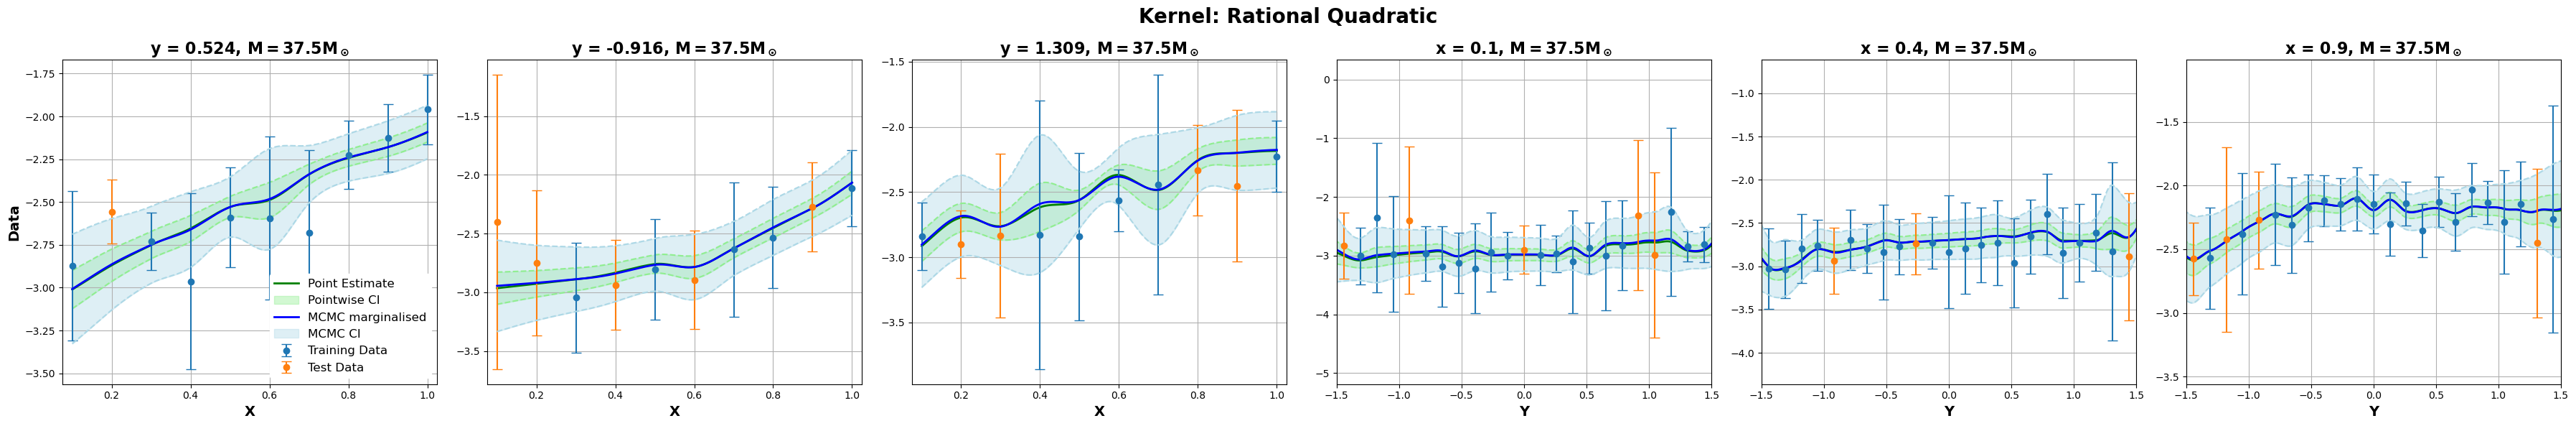

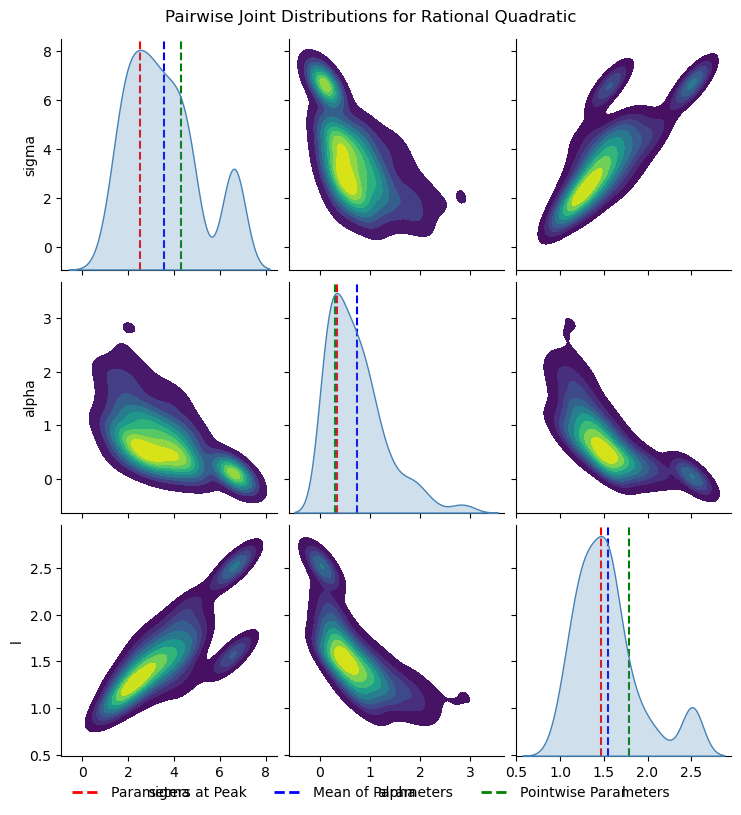

sigma = 1.1542629387131134
l = 0.47239740760157045
periodicity = 11.28204572305942


  0%|          | 0/500 [00:00<?, ?it/s]c:\Users\seanw\anaconda3\Lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 500/500 [01:07<00:00,  7.45it/s]

acceptance fraction = 0.043000000000000003



Running GP Predictions: 100%|██████████| 312/312 [00:35<00:00,  8.82sample/s]


Fitted Kernel: 1.02**2 * ExpSineSquared(length_scale=0.761, periodicity=7.43)


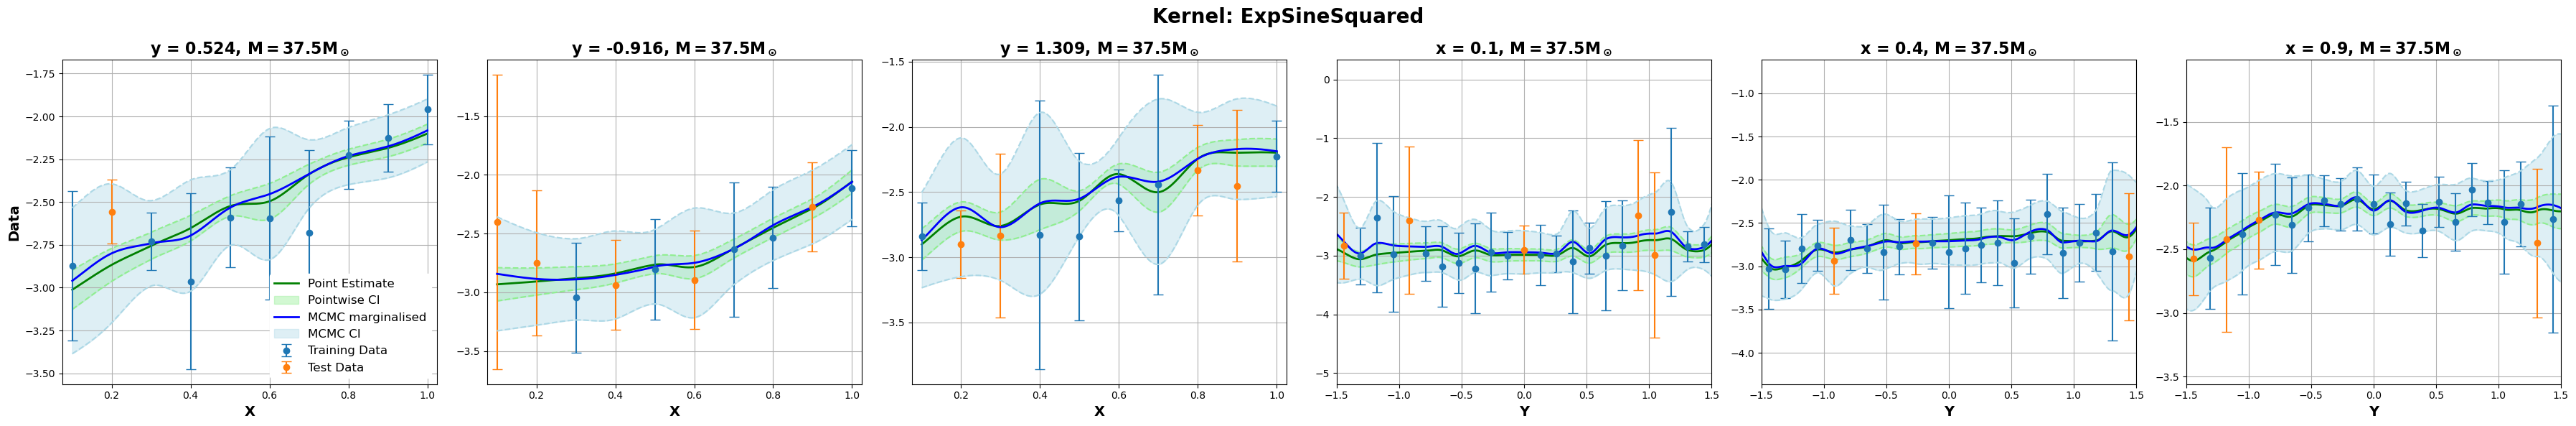

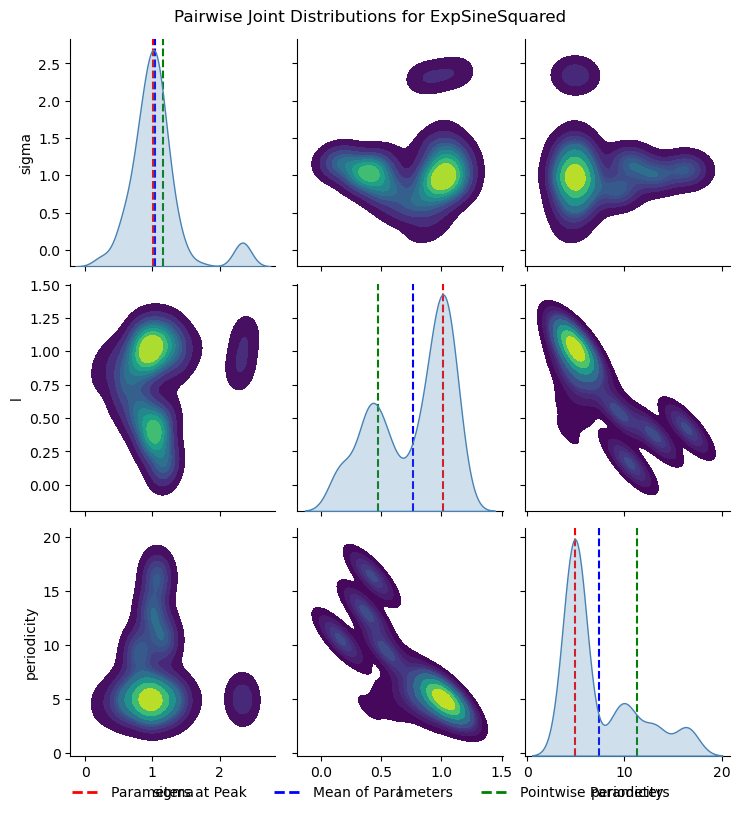

c:\Users\seanw\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


sigma = 1.2533539111996768
gamma = 0.2502837702930708


100%|██████████| 500/500 [01:25<00:00,  5.84it/s]

acceptance fraction = 0.3085



Running GP Predictions: 100%|██████████| 208/208 [00:30<00:00,  6.89sample/s]


Fitted Kernel: 1.25**2 * PairwiseKernel(gamma=0.23499309950482453, metric=laplacian)


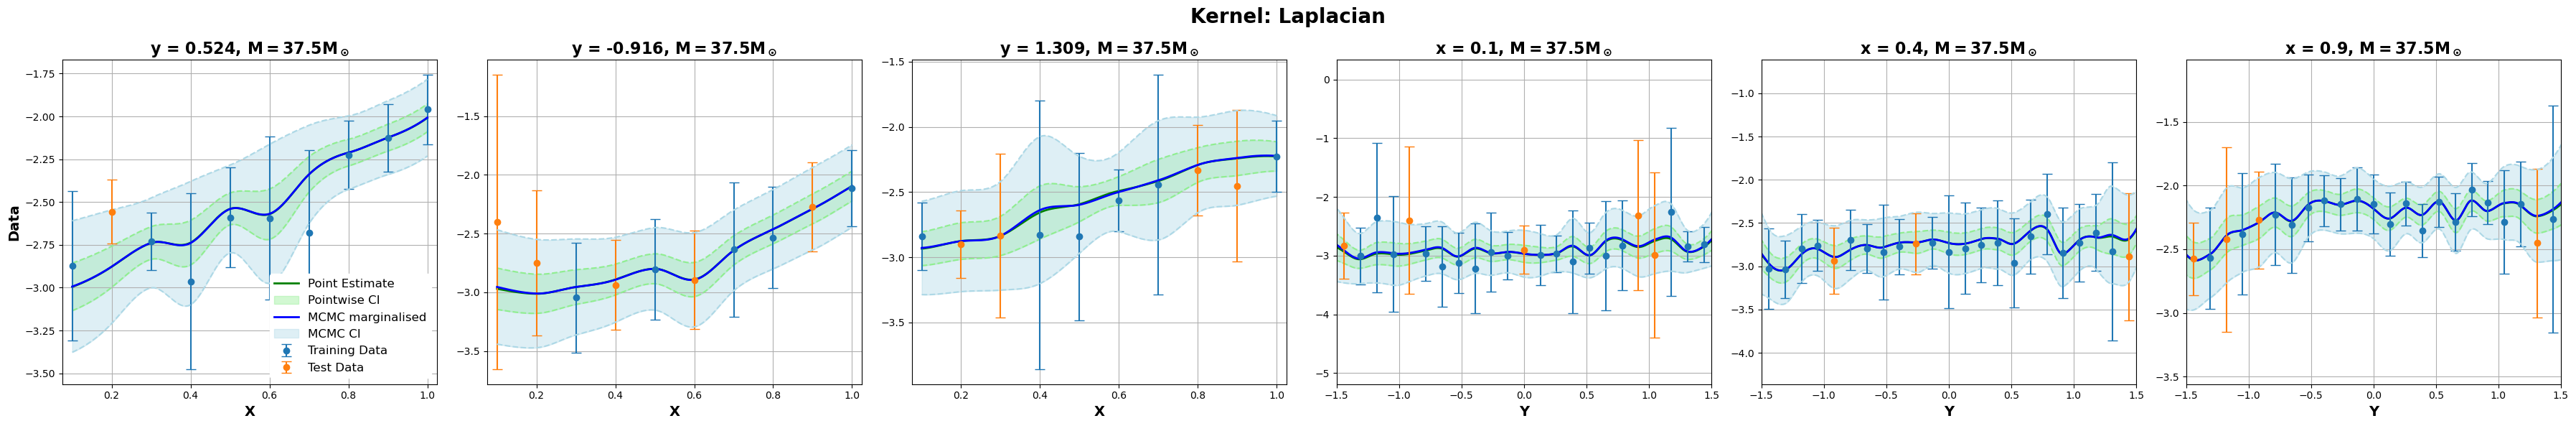

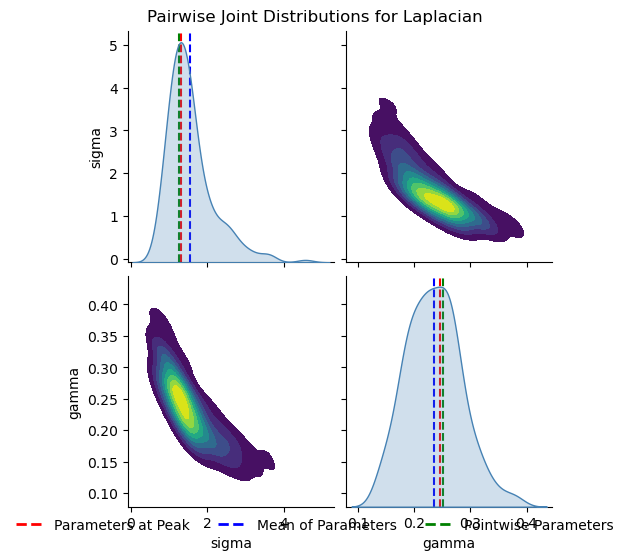

sigma = 0.6009690454941182
l1 = 0.20756257886465224
l2 = 0.762790921637476
l3 = 0.6980066705615466
l4 = 2.0129349667438974


100%|██████████| 500/500 [03:03<00:00,  2.72it/s]

acceptance fraction = 0.11800000000000002



Running GP Predictions: 100%|██████████| 520/520 [00:37<00:00, 13.97sample/s]


Fitted Kernel: 0.952**2 * RBF(length_scale=[0.233, 0.619, 1, 2.52])


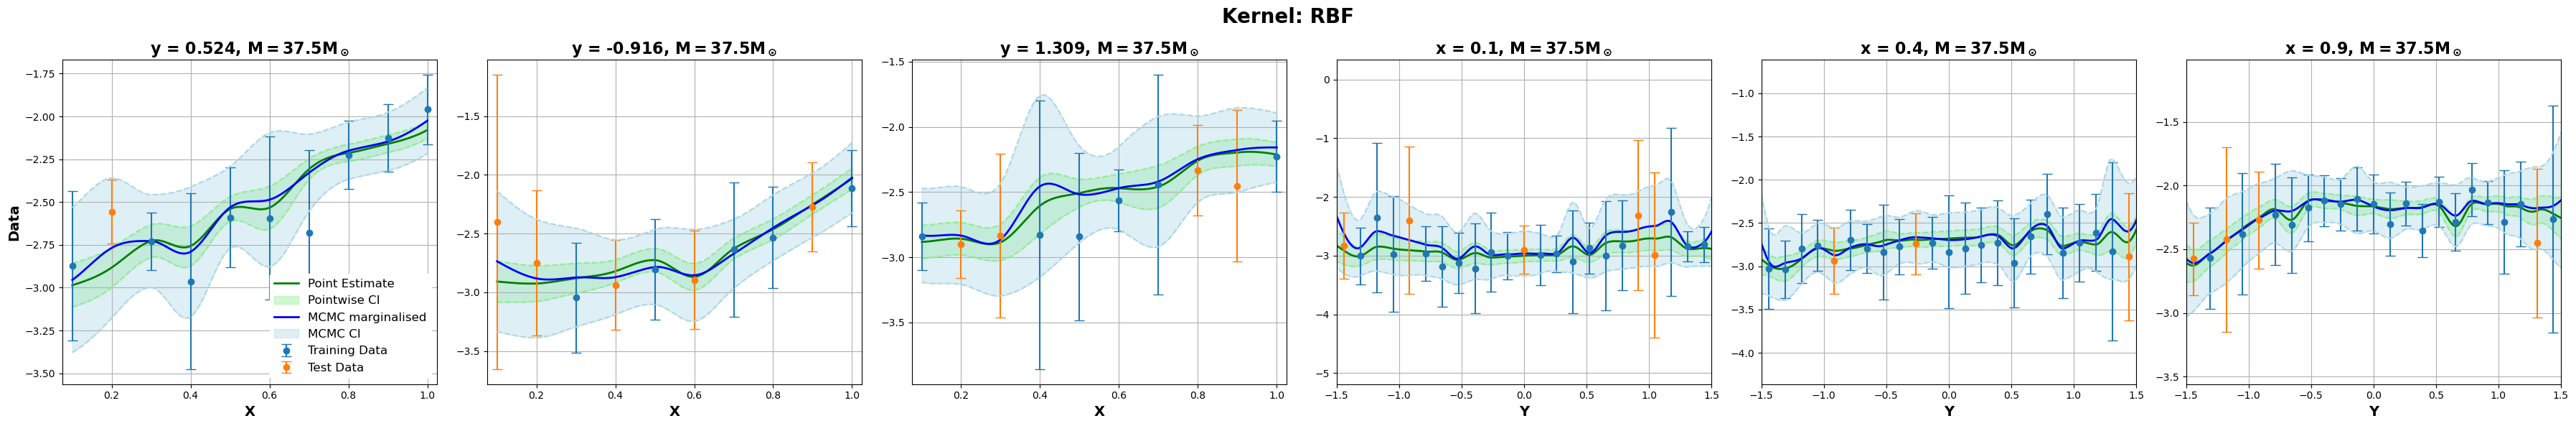

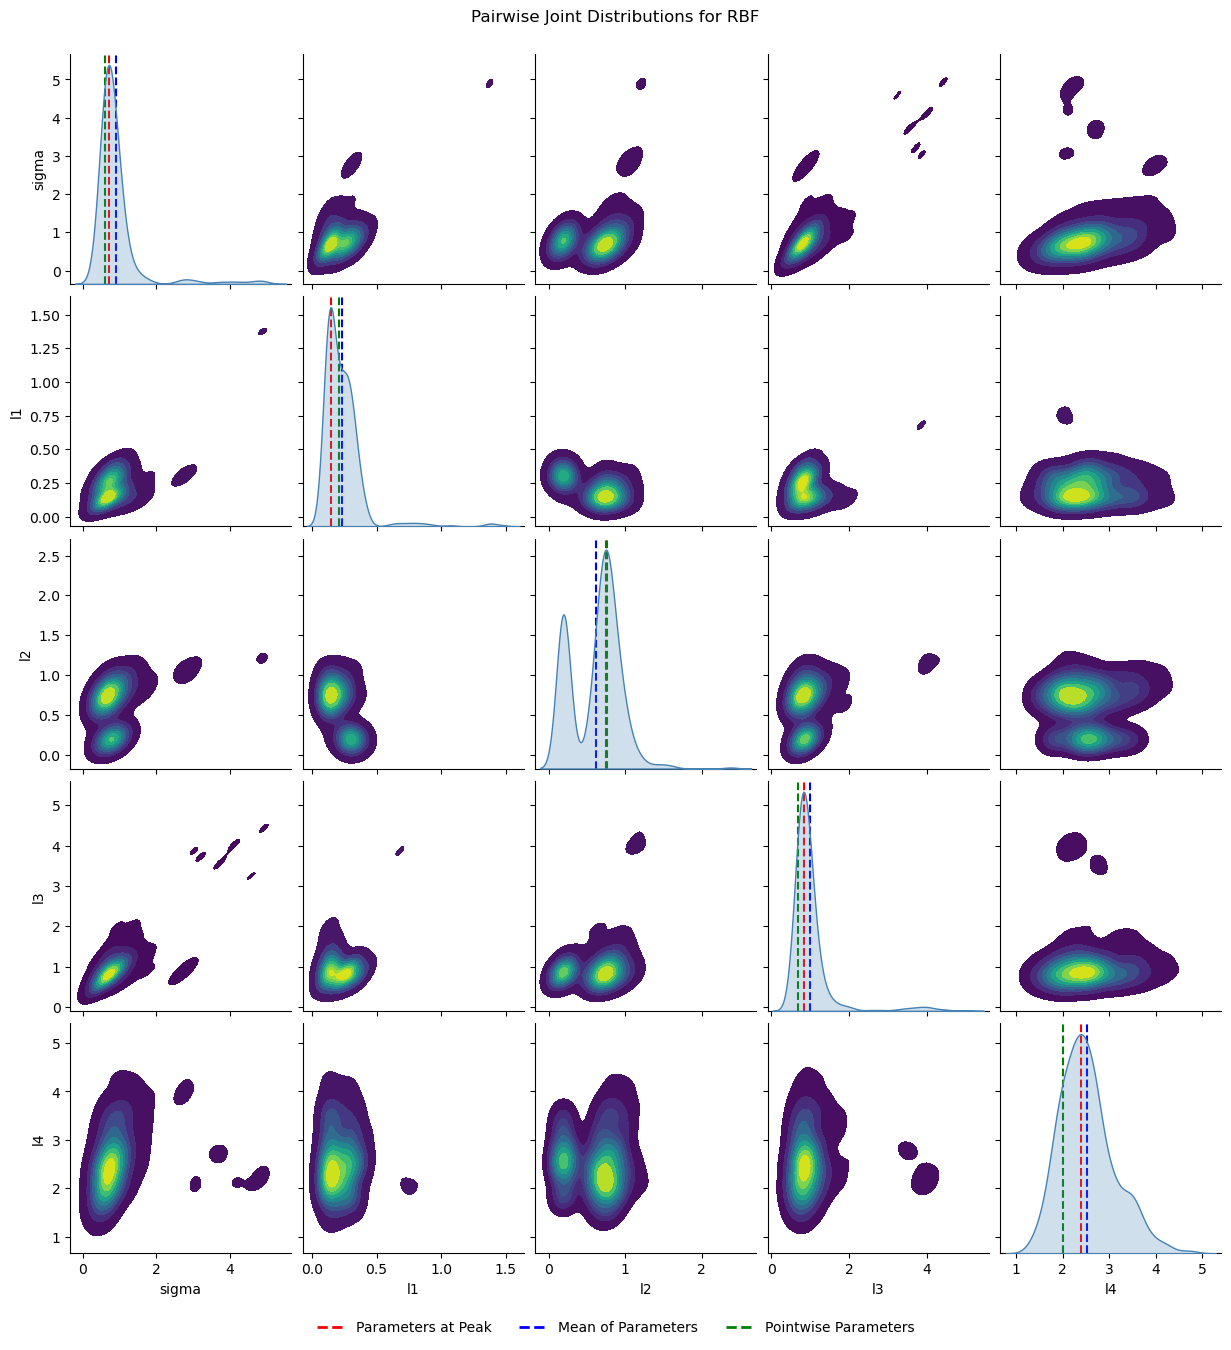

sigma = 0.8472284268279076
l1 = 0.28242888703172475
l2 = 0.7979297800004849
l3 = 1.4668235969874241
l4 = 4.208967727852938


  0%|          | 0/500 [00:00<?, ?it/s]c:\Users\seanw\anaconda3\Lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 500/500 [18:55<00:00,  2.27s/it]

acceptance fraction = 0.2589



Running GP Predictions: 100%|██████████| 520/520 [04:00<00:00,  2.16sample/s]


Fitted Kernel: 1.1**2 * Matern(length_scale=[0.478, 0.781, 1.7, 4.86], nu=1.75)


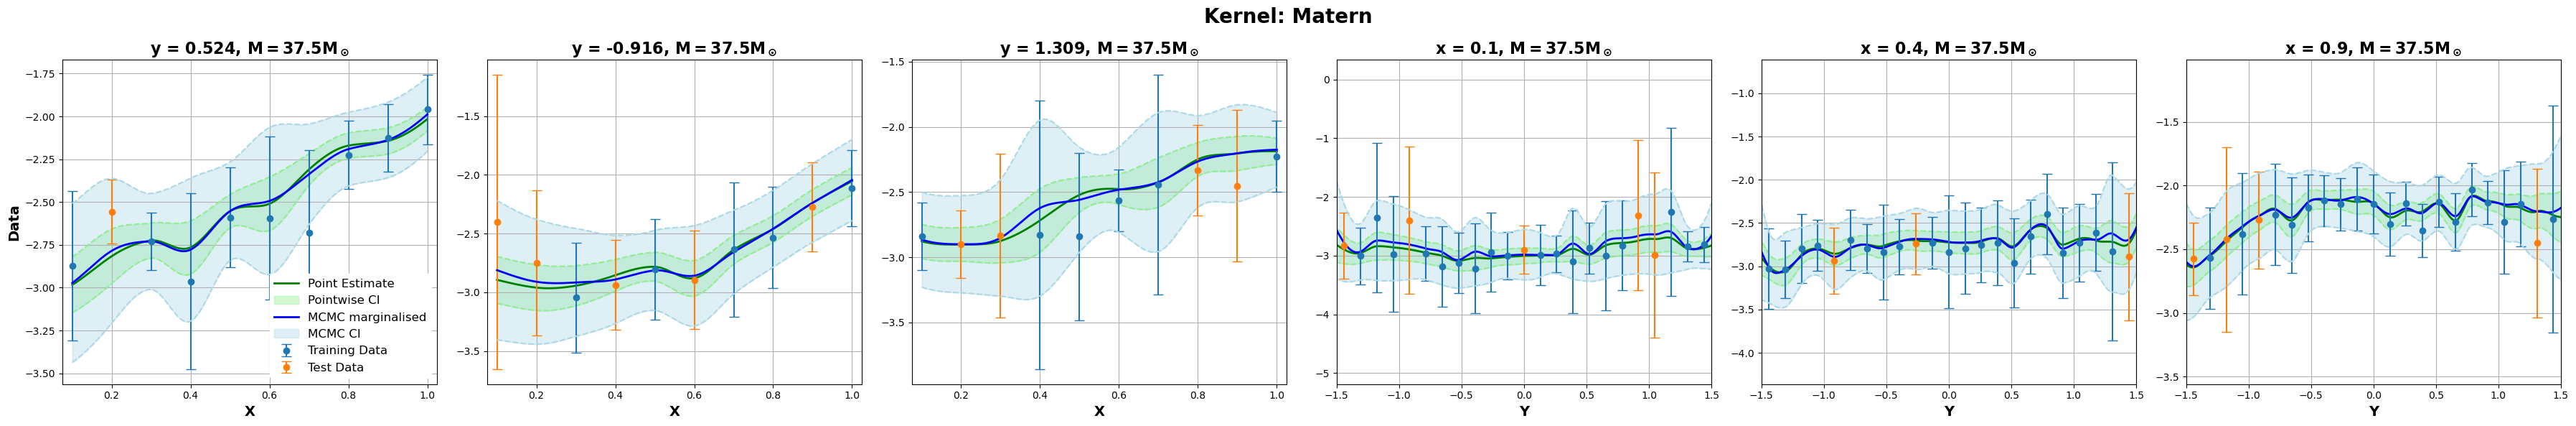

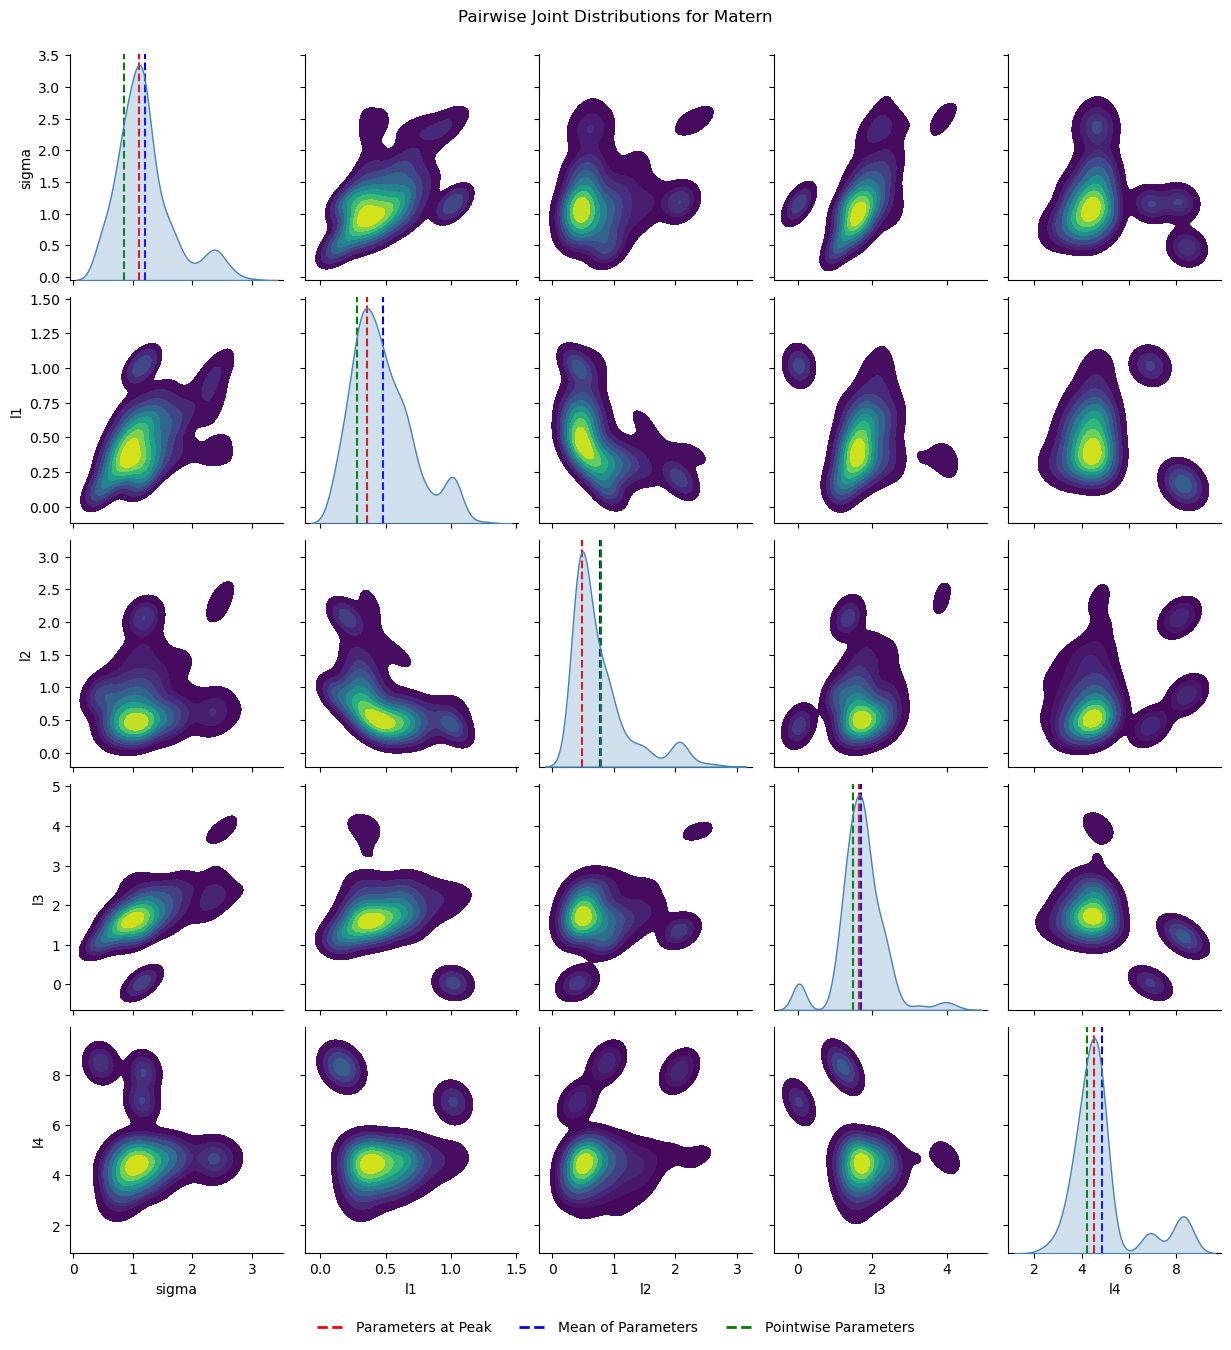

In [199]:
titles = [
    f"y = {round(ypoints[0], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$",
    f"y = {round(ypoints[1], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$",
    f"y = {round(ypoints[2], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$",
    f"x = {round(xpoints2[0], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$",
    f"x = {round(xpoints2[1], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$",
    f"x = {round(xpoints2[2], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$"
]

fillcolors = ["lightgreen", "lightblue"]
colors = ["green", "blue"]
meanlabels = ["Point Estimate", "MCMC marginalised"]
cilabels = ["Pointwise CI", "MCMC CI"]

#LogLike = np.zeros((len(kernel_list),2))
rmse_values = np.zeros((len(kernel_list),4))
mae_values = np.zeros((len(kernel_list),4))
r2_values = np.zeros((len(kernel_list),4))
adjusted_r2_values= np.zeros((len(kernel_list),4))
fom_values = np.zeros((len(kernel_list),4))


for k, kernel in enumerate(kernel_list):

    fits, stds, pointwiseparams,samples,flat_samples,rmse, mae, r2, adjustedr2, fom = MCMCGPR(kernel,X_train,D_train,E_train,X1,X1_test,D1_test,parammult[k],DEmovegamma[k],dimensionnames[k])

    fig, axes = plt.subplots(1, 6, figsize=(36, 6), sharey=False)
    for i, ax in enumerate(axes):
        for j in range(4):
            if (j==0 or j==1):
                if (i<=2):
                    zgridlinear_mean = griddata((xm1, ym1), fits[j], (xpoints, ypoints[i]), method="cubic")
                    zgridlinear_std = griddata((xm1, ym1),stds[j], (xpoints, ypoints[i]), method="cubic")
                    indices1 = np.isclose(y1train,ypoints[i])
                    indices2 = np.isclose(y1test,ypoints[i])
                    if(j==1):
                        ax.errorbar(x1train[indices1].ravel(), D1_train[indices1].ravel(), yerr=E1_train[indices1].ravel(), fmt='o', capsize=5,label = 'Training Data')
                        ax.errorbar(x1test[indices2].ravel(),D1_test[indices2].ravel(), yerr=E1_test[indices2].ravel(), fmt='o', capsize=5,label = 'Test Data')
                    ax.plot(xpoints,zgridlinear_mean,label=meanlabels[j], color=colors[j], linewidth=2)
                    ax.fill_between(xpoints, 
                            zgridlinear_mean - 2*zgridlinear_std, 
                            zgridlinear_mean + 2*zgridlinear_std, 
                            color=fillcolors[j], alpha=0.4, label=cilabels[j])
                    ax.plot(xpoints, zgridlinear_mean - 2*zgridlinear_std, '--', color=fillcolors[j], linewidth=1.5)
                    ax.plot(xpoints, zgridlinear_mean + 2*zgridlinear_std, '--', color=fillcolors[j], linewidth=1.5)
                    ax.set_xlim((0.075, 1.025))
                    ax.set_xlabel('X', fontsize=14, weight='bold')
                    ax.set_title(titles[i], fontsize=16, weight='bold')
                    ax.grid(True)
                else:
                    xpoint = xpoints2[i-3]
                    zgridlinear_mean = griddata((xm1, ym1), fits[j], (xpoint, ypoints2), method="cubic")
                    zgridlinear_std = griddata((xm1, ym1), stds[j], (xpoint, ypoints2), method="cubic")
                    indices1 = np.isclose(x1train,xpoints2[i-3])
                    indices2 = np.isclose(x1test,xpoints2[i-3])
                    ax.plot(ypoints2, zgridlinear_mean, label=meanlabels[j], color=colors[j], linewidth=2)
                    if(j==1):
                        ax.errorbar(y1train[indices1].ravel(), D1_train[indices1].ravel(), yerr=E1_train[indices1].ravel(),fmt='o', capsize=5,label = 'Training Data')
                        ax.errorbar(y1test[indices2].ravel(),D1_test[indices2].ravel(), yerr=E1_test[indices2].ravel(), fmt='o', capsize=5,label = 'Test Data')   
                    ax.fill_between(ypoints2, 
                                    zgridlinear_mean - 2*zgridlinear_std, 
                                    zgridlinear_mean + 2*zgridlinear_std, 
                                    color=fillcolors[j], alpha=0.4, label=cilabels[j])
                    ax.plot(ypoints2, zgridlinear_mean - 2*zgridlinear_std, '--', color=fillcolors[j], linewidth=1.5)
                    ax.plot(ypoints2, zgridlinear_mean + 2*zgridlinear_std, '--', color=fillcolors[j], linewidth=1.5)        
                    ax.set_xlim((-1.5, 1.5))
                    ax.set_xlabel('Y', fontsize=14, weight='bold')
                    ax.set_title(titles[i], fontsize=16, weight='bold')
                    ax.grid(True)          
            ### Performance metrics
            rmse_values[k,j] = rmse[j]
            mae_values[k,j] = mae[j]
            r2_values[k,j] = r2[j]
            adjusted_r2_values[k,j] = adjustedr2[j]
            fom_values[k,j] = fom[j]  
    axes[0].set_ylabel('Data', fontsize=14, weight='bold')
    legend = axes[0].legend(fontsize=12,loc='lower right',frameon=True)
    legend.get_frame().set_facecolor('white')  # Set the background color to grey
    legend.get_frame().set_edgecolor('white')  # Optional: Add a black edge to the frame
    legend.get_frame().set_alpha(1)  # Optional: Set opacity (1 = solid)
    fig.suptitle(f"Kernel: {kernel_names[kernel_list.index(kernel)]}", fontsize=20, weight='bold')
    plt.tight_layout()
    plt.show()

    distributionplots(samples, flat_samples, pointwiseparams,dimensionnames[kernel_list.index(kernel)],kernel_names[kernel_list.index(kernel)])

### Plotting the Accuracy Metrics to help choose which model to predict with

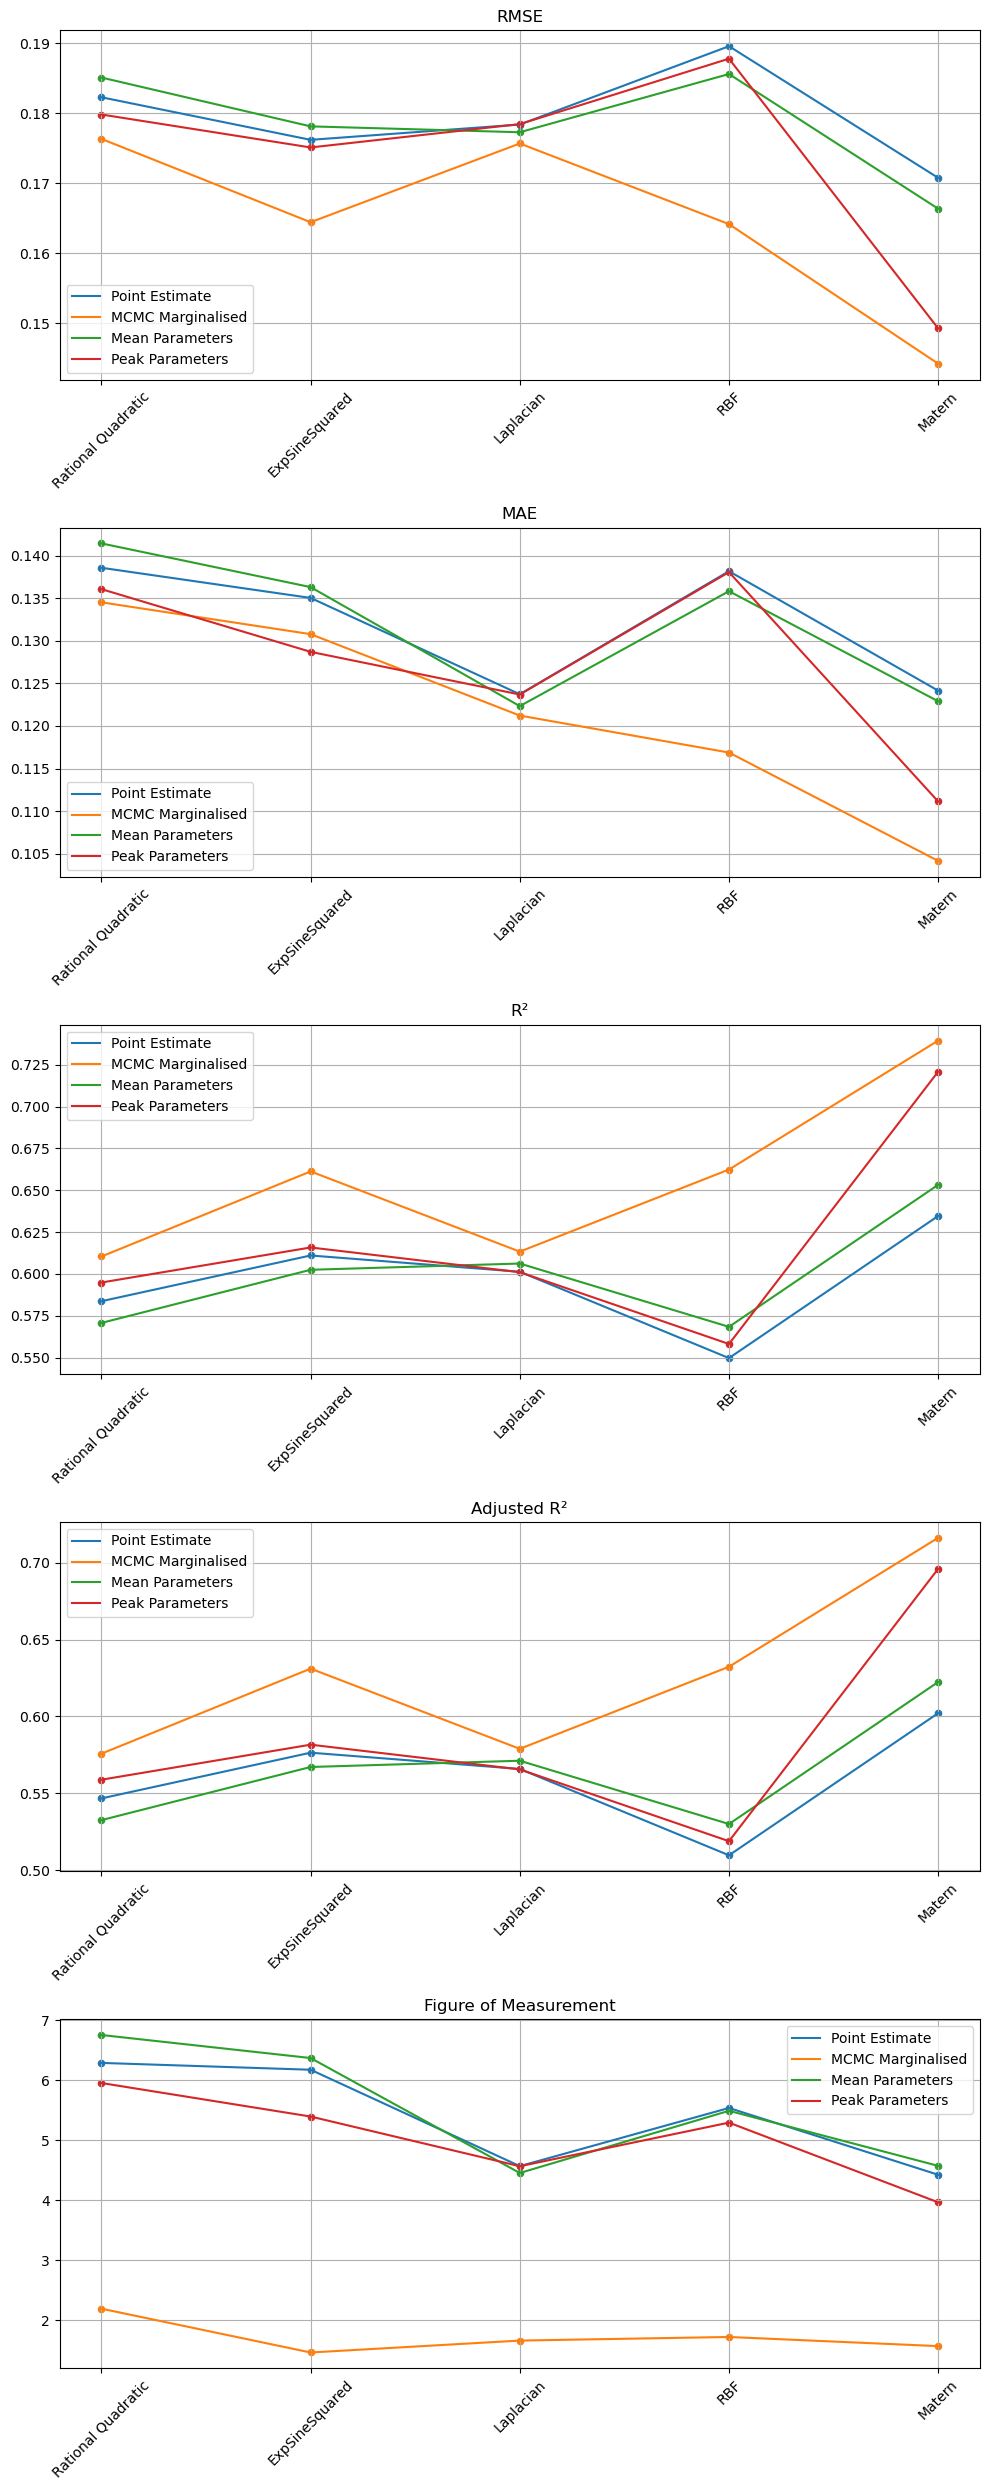

In [211]:
metrics = [rmse_values, mae_values, r2_values, adjusted_r2_values, fom_values]
metric_names = ["RMSE", "MAE", "R²", "Adjusted R²", "Figure of Measurement"]
fitlabels = ["Point Estimate", "MCMC Marginalised", "Mean Parameters", "Peak Parameters"]

# Distinct colors for the fits (4 colors)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

fig, axes = plt.subplots(len(metrics), 1, figsize=(10, 25))

x = range(len(kernel_names))
x_ticks = np.arange(len(kernel_names))

for i, ax in enumerate(axes):
    metric = metrics[i]  
    for j in range(metric.shape[1]):
        for k, (xi, yi) in enumerate(zip(x, metric[:, j])):
            ax.scatter(xi, yi, marker='o', s=20, color=colors[j])
            # Annotate with kernel name and the corresponding value (formatted to 2 decimals)
            #ax.text(xi, yi, f"{kernel_names[k]}\n{yi:.2f}", fontsize=8,
            #        ha='right', va='center')
        # Optionally, you can draw a connecting line between points for each fit
        ax.plot(x, metric[:, j], linestyle='-', color=colors[j], label=fitlabels[j])
    ax.set_xticks(x_ticks, kernel_names, rotation=45)
    ax.set_title(metric_names[i])
    ax.set_xticks(x)
    #ax.set_xticklabels(kernel_names, rotation=45)
    ax.grid(True)
    ax.legend(loc='best')
    ax.grid(True)

#axes[-1].set_xlabel("Kernel")
plt.tight_layout()
plt.show()



### Results seem to be that the best results are achieved with the Matern Kernel marginalizing over all samples and then the next best is the GPR with the peak hyper-parameters found after MCMC sampling